# Задача 7. Нейронные сети

* **Дедлайн**: 28.03.2025, 23:59
* **Основной полный балл**: 5
* **Максимум баллов**: 10

## Задача

-  Найти данные в виде изображений для задачи классификации. Например, можно взять данные [отсюда](http://ufldl.stanford.edu/housenumbers/).
-  Реализовать классы, необходимые для построения сети со следующими слоями
	- FullyConnectedLayer
	- ReluLayer
	- FullyConnectedLayer
-  Использовать CrossEntropyLoss и L2-регуляризацию.
-  Обучить модель на тренировочных данных, подбирать параметры (особенно learning rate) на валидационной и оценить качество на тестовой. Анализировать графики train/val loss, проверять на каждом шаге корректность вычисления градиентов с помощью разностной оценки.
-  (**+2 балла**) Добавить Batch normalization.
-  (**+2 балла**) В качестве оптимизатор использовать один из: Momentum, RMSprop.
-  (**+1 балл**) Также реализовать оптимизатор Adam.


## Импорты и константы

In [183]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor, Normalize, Compose
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt


torch.manual_seed(777)

BATCH_SIZE = 128
EPOCHS = 20
LEARNING_RATES = [1e-2, 1e-3, 1e-4]
WEIGHT_DECAY = 1e-4


## Датасет

Был выбран датасет из PyTorch **MNIST**

**MNIST** — это популярный датасет изображений цифр от 0 до 9, разделенных на 60,000 обучающих и 10,000.

Каждое изображение:
- Размер: 28 × 28 пикселей.
- Оттенки серого (grayscale): значения от 0 до 255.
- Метка (label): целое число от 0 до 9, соответствующее цифре на изображении.

## Подготовка, разделение и просмотр датасета

Size of sets:
    * Training samples: 54000
    * Validation samples: 6000
    * Test samples: 10000


Samples from sets(16 of each)




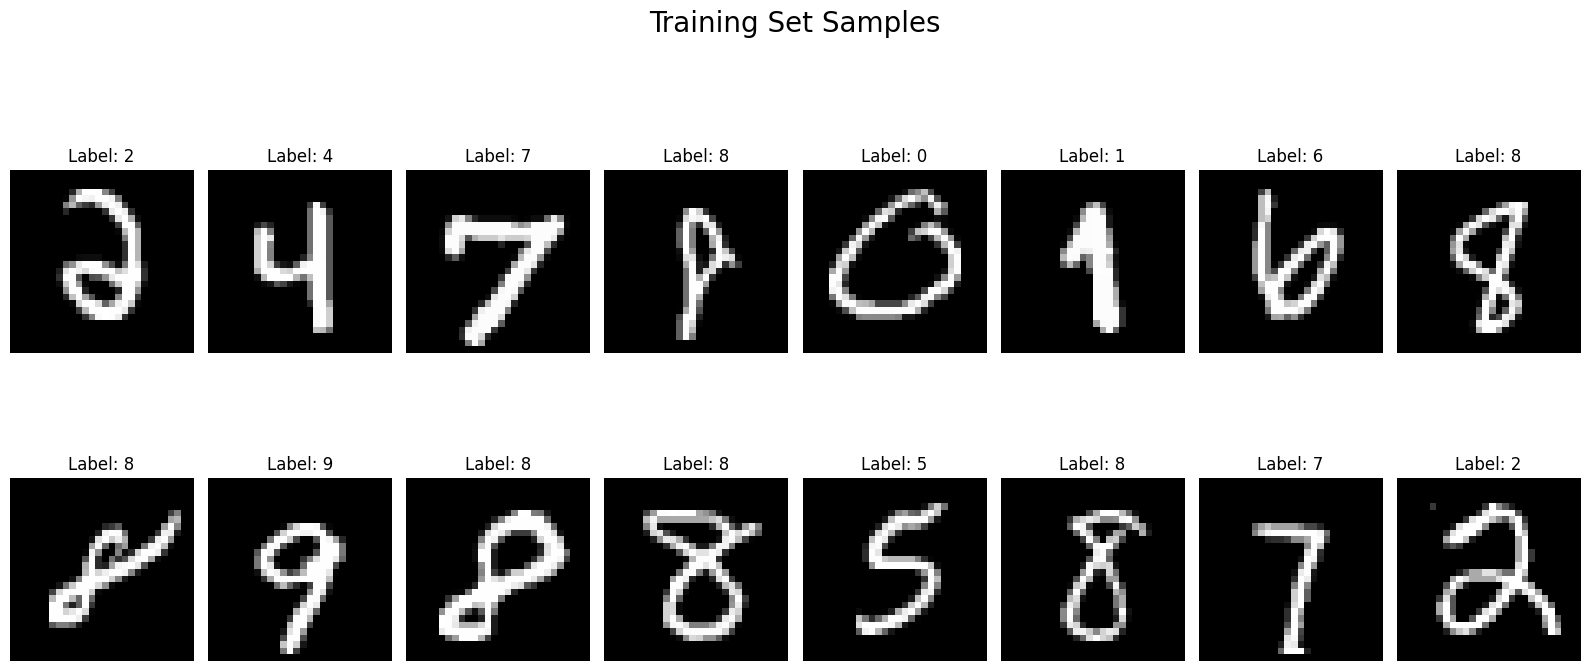

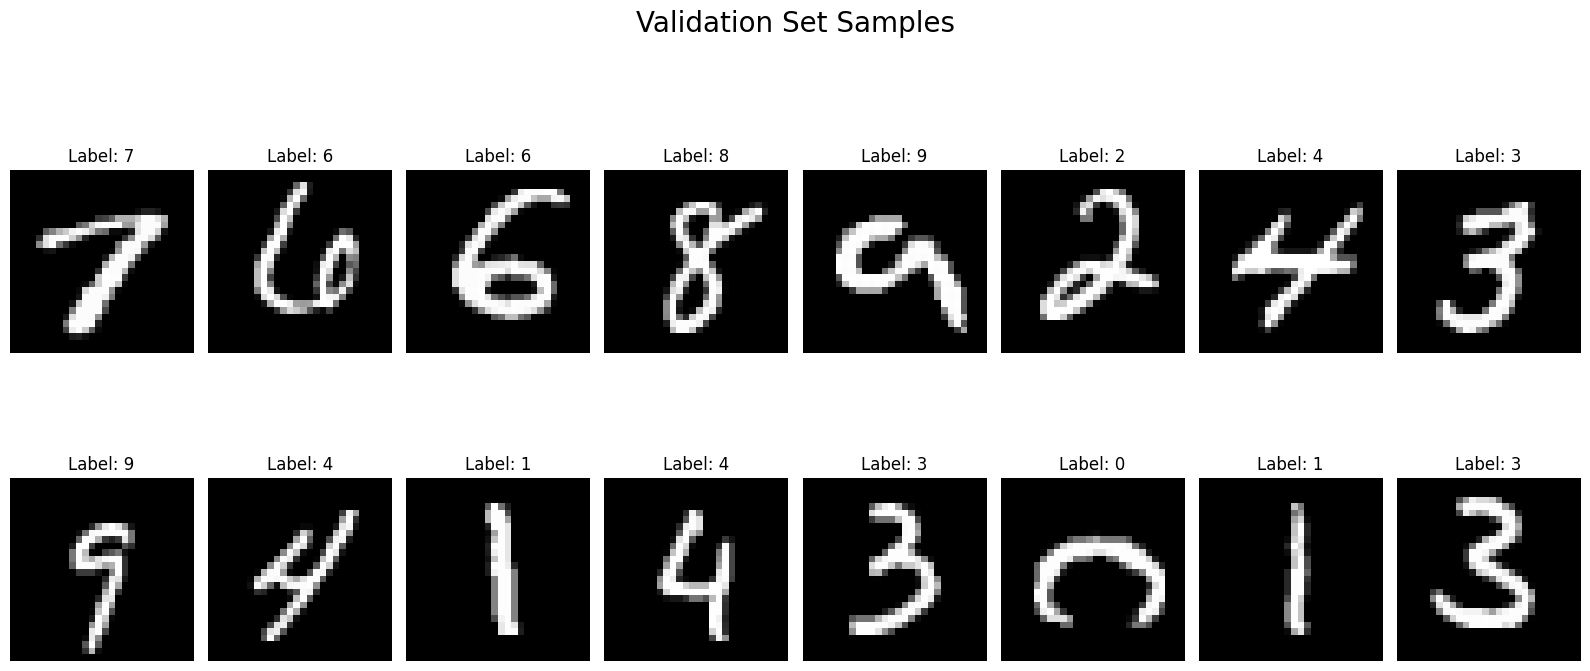

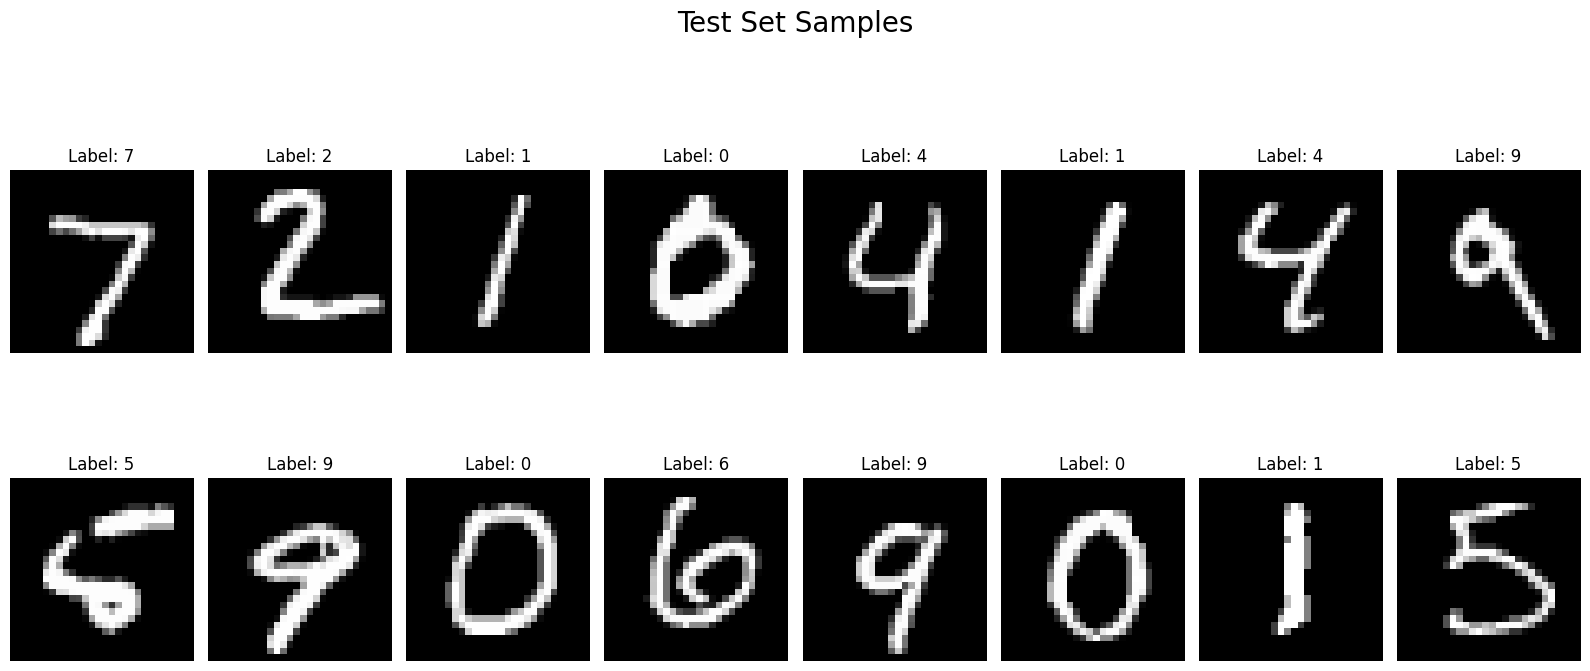

In [184]:
data_transforms = Compose([
    ToTensor(),
    Normalize((0.1307,), (0.3081,))
])


train_val_dataset = MNIST(root='.', train=True, transform=data_transforms, download=True)
test_dataset = MNIST(root='.', train=False, transform=data_transforms, download=True)

train_size = int(0.9 * len(train_val_dataset))
val_size = len(train_val_dataset) - train_size
train_dataset, val_dataset = random_split(train_val_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

def plot_samples(loader, title):
    dataiter = iter(loader)
    images, labels = next(dataiter)

    fig, axes = plt.subplots(2, 8, figsize=(16, 8))
    axes = axes.ravel()

    for idx in range(16):
        img = images[idx].numpy().squeeze()
        axes[idx].imshow(img, cmap='gray')
        axes[idx].axis('off')
        axes[idx].set_title(f"Label: {labels[idx].item()}")

    plt.suptitle(title, fontsize=20)
    plt.tight_layout()
    plt.show()

print("Size of sets:")
print(f"    * Training samples: {len(train_dataset)}")
print(f"    * Validation samples: {len(val_dataset)}")
print(f"    * Test samples: {len(test_dataset)}")

print("\n\nSamples from sets(16 of each)\n\n")
plot_samples(train_loader, "Training Set Samples")
plot_samples(val_loader, "Validation Set Samples")
plot_samples(test_loader, "Test Set Samples")

## Реализуем классы слоев и модели

In [185]:
# === Кастомные слои ===
class FullyConnectedLayer(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.linear = nn.Linear(in_features, out_features)

    def forward(self, x):
        return self.linear(x)


class ReluLayer(nn.Module):
    def forward(self, x):
        return F.relu(x)

class MyNetwork(nn.Module):
    def __init__(self, use_batchnorm=False):
        super().__init__()
        self.layers = nn.ModuleList()
        self.layers.append(FullyConnectedLayer(28 * 28, 256))
        if use_batchnorm:
            self.layers.append(nn.BatchNorm1d(256))
        self.layers.append(ReluLayer())
        self.layers.append(FullyConnectedLayer(256, 10))

    def forward(self, x):
        x = x.view(x.size(0), -1)
        for layer in self.layers:
            x = layer(x)
        return x


## Реализация Адама



In [186]:
class CustomAdam(optim.Optimizer):
    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8):
        defaults = dict(lr=lr, betas=betas, eps=eps)
        super().__init__(params, defaults)

    def step(self, closure=None):
        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data
                if grad.is_sparse:
                    raise RuntimeError("Adam does not support sparse gradients")
                state = self.state[p]

                if len(state) == 0:
                    state['step'] = 0
                    state['exp_avg'] = torch.zeros_like(p.data)
                    state['exp_avg_sq'] = torch.zeros_like(p.data)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                beta1, beta2 = group['betas']

                state['step'] += 1
                exp_avg.mul_(beta1).add_(grad, alpha=1 - beta1)
                exp_avg_sq.mul_(beta2).addcmul_(grad, grad, value=1 - beta2)

                denom = exp_avg_sq.sqrt().add_(group['eps'])
                bias_correction1 = 1 - beta1 ** state['step']
                bias_correction2 = 1 - beta2 ** state['step']
                step_size = group['lr'] * (bias_correction2 ** 0.5) / bias_correction1

                p.data.addcdiv_(exp_avg, denom, value=-step_size)

## Trainer

TrainerWrapper — это вспомогательный класс, который оборачивает всю логику обучения, валидации, тестирования и проверки градиентов модели.

Содержит:
- Функция потерь (в частности CrossEntropy)
- Оптимизатор с L2-регуляцией
- Градиент-чек

In [187]:
class TrainerWrapper:
    def __init__(self, model, optimizer, loss_fn, l2=0.0):
        self.model = model
        self.optimizer = optimizer
        self.loss_fn = loss_fn
        self.l2 = l2
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model.to(self.device)

    def train(self, train_loader, val_loader, epochs):
        train_losses, val_losses = [], []
        for epoch in range(epochs):
            self.model.train()
            total_loss = 0
            for i, c in enumerate(train_loader):
                x, y = c
                x, y = x.to(self.device), y.to(self.device)
                self.optimizer.zero_grad()
                logits = self.model(x)
                loss = self.loss_fn(logits, y) + self.l2 * sum((p**2).sum() for p in self.model.parameters())
                loss.backward()
                self.optimizer.step()
                if i % 100 == 0:
                    self._gradient_check(x, y)
                total_loss += loss.item()
            train_losses.append(total_loss / len(train_loader))

            self.model.eval()
            val_loss = 0
            with torch.no_grad():
                for x, y in val_loader:
                    x, y = x.to(self.device), y.to(self.device)
                    logits = self.model(x)
                    val_loss += self.loss_fn(logits, y).item()
            val_losses.append(val_loss / len(val_loader))

        return train_losses, val_losses

    def accuracy(self, loader):
        self.model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for x, y in loader:
                x, y = x.to(self.device), y.to(self.device)
                preds = self.model(x).argmax(dim=1)
                correct += (preds == y).sum().item()
                total += y.size(0)
        return correct / total

    def _gradient_check(self, x, y, eps=1e-4, num_checks=10):
        x = x.to(self.device)
        y = y.to(self.device)

        self.model.eval()
        x = x.clone().detach().requires_grad_(True)
        logits = self.model(x)
        logits.retain_grad()
        loss = self.loss_fn(logits, y)
        loss.backward()

        analytic_grad = logits.grad.view(-1)
        numerical_grad = torch.zeros_like(analytic_grad)

        indices = torch.randperm(analytic_grad.numel())[:num_checks]

        for i in indices:
            logits_perturbed = logits.clone().detach()

            logits_perturbed.view(-1)[i] += eps
            loss_plus = self.loss_fn(logits_perturbed, y).item()

            logits_perturbed.view(-1)[i] -= 2 * eps
            loss_minus = self.loss_fn(logits_perturbed, y).item()

            numerical_grad[i] = (loss_plus - loss_minus) / (2 * eps)

        diff = analytic_grad[indices] - numerical_grad[indices]
        rel_error = torch.norm(diff) / (torch.norm(analytic_grad[indices]) + torch.norm(numerical_grad[indices]) + 1e-8)

## Эксперимент и результаты(валидационный лоадер)

Комбинации параметров: 3 оптимизатора (CustomAdam, RMSprop, SGD) * использован ли Batch normalization (да / нет) * learning rate ([1e-2, 1e-3, 1e-4]). Итого 3 * 2 * 3 = 18 комбинаций

Количество эпох фиксированно и равно 20

Далее мы проверим на валидационной топ 5 лучших параметров, зафиксируем их и проверим на тестовой

In [188]:
optimizers = {
    'Adam': lambda params, lr: CustomAdam(params, lr=lr),
    'RMSprop': lambda params, lr: optim.RMSprop(params, lr=lr),
    'SGD': lambda params, lr: optim.SGD(params, lr=lr, momentum=0.9)
}

results = {}

for opt_name, opt_fn in optimizers.items():
    for lr in LEARNING_RATES:
        for use_bn in [False, True]:
            tag = f"{opt_name}, lr = {lr}, use_batchnorm = {use_bn}"
            model = MyNetwork(use_batchnorm=use_bn)
            optimizer = opt_fn(model.parameters(), lr)
            trainer = TrainerWrapper(model, optimizer, nn.CrossEntropyLoss(), l2=WEIGHT_DECAY)
            train_loss, val_loss = trainer.train(train_loader, val_loader, EPOCHS)
            acc = trainer.accuracy(val_loader)
            results[tag] = {
                'train_loss': train_loss,
                'val_loss': val_loss,
                'val_acc': acc,
                'trainer': trainer,
            }
            print(f"{tag}: Val Acc = {acc:.4f}")

Adam, lr = 0.01, use_batchnorm = False: Val Acc = 0.9430
Adam, lr = 0.01, use_batchnorm = True: Val Acc = 0.9583
Adam, lr = 0.001, use_batchnorm = False: Val Acc = 0.9783
Adam, lr = 0.001, use_batchnorm = True: Val Acc = 0.9758
Adam, lr = 0.0001, use_batchnorm = False: Val Acc = 0.9725
Adam, lr = 0.0001, use_batchnorm = True: Val Acc = 0.9687
RMSprop, lr = 0.01, use_batchnorm = False: Val Acc = 0.9303
RMSprop, lr = 0.01, use_batchnorm = True: Val Acc = 0.9608
RMSprop, lr = 0.001, use_batchnorm = False: Val Acc = 0.9788
RMSprop, lr = 0.001, use_batchnorm = True: Val Acc = 0.9782
RMSprop, lr = 0.0001, use_batchnorm = False: Val Acc = 0.9738
RMSprop, lr = 0.0001, use_batchnorm = True: Val Acc = 0.9687
SGD, lr = 0.01, use_batchnorm = False: Val Acc = 0.9780
SGD, lr = 0.01, use_batchnorm = True: Val Acc = 0.9780
SGD, lr = 0.001, use_batchnorm = False: Val Acc = 0.9555
SGD, lr = 0.001, use_batchnorm = True: Val Acc = 0.9553
SGD, lr = 0.0001, use_batchnorm = False: Val Acc = 0.9003
SGD, lr = 

## Графики(валидационный лоадер)

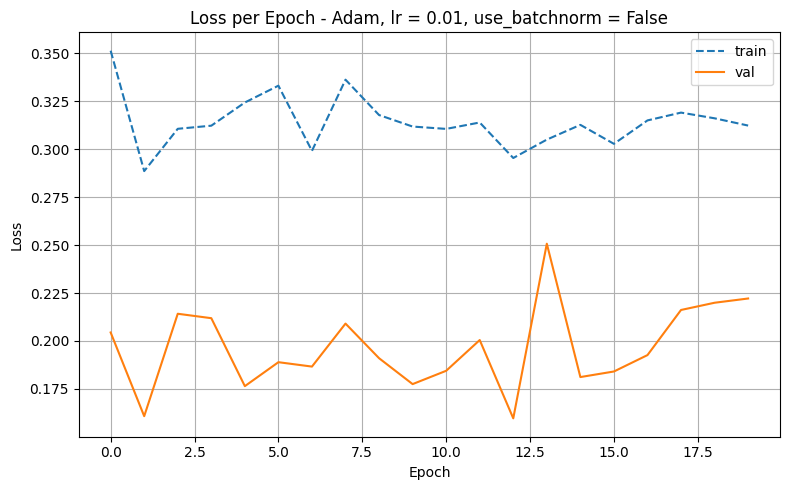

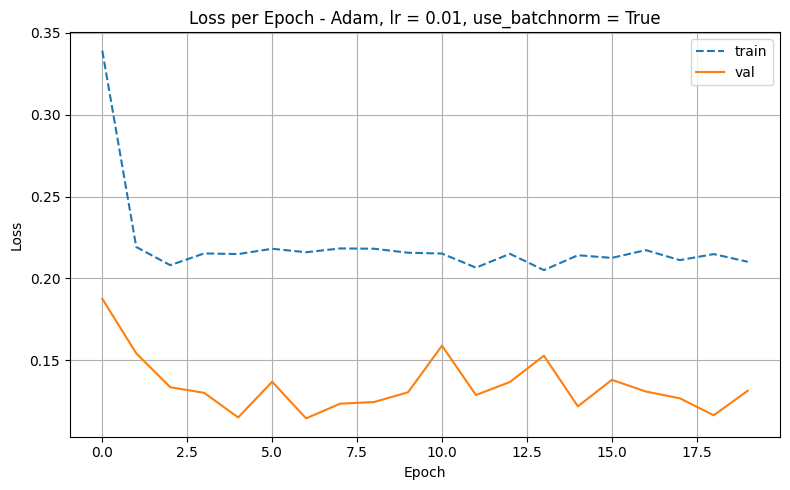

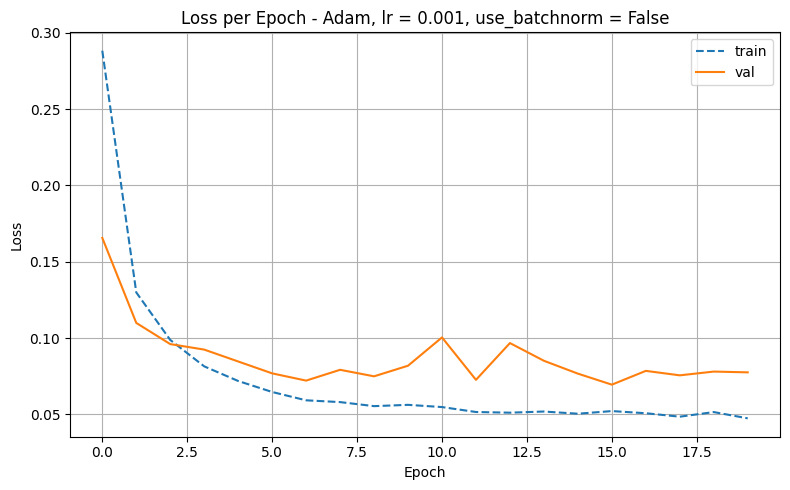

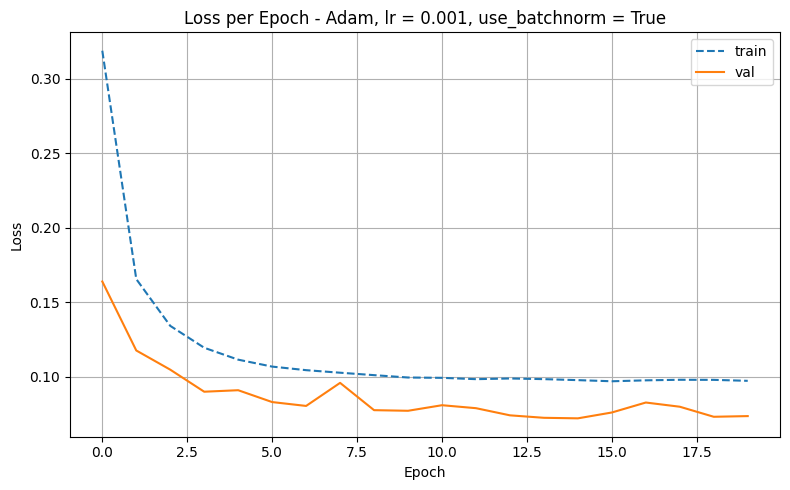

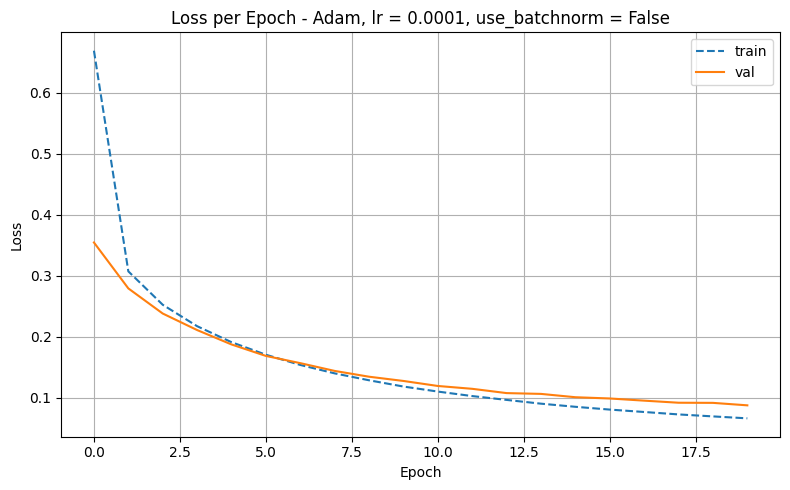

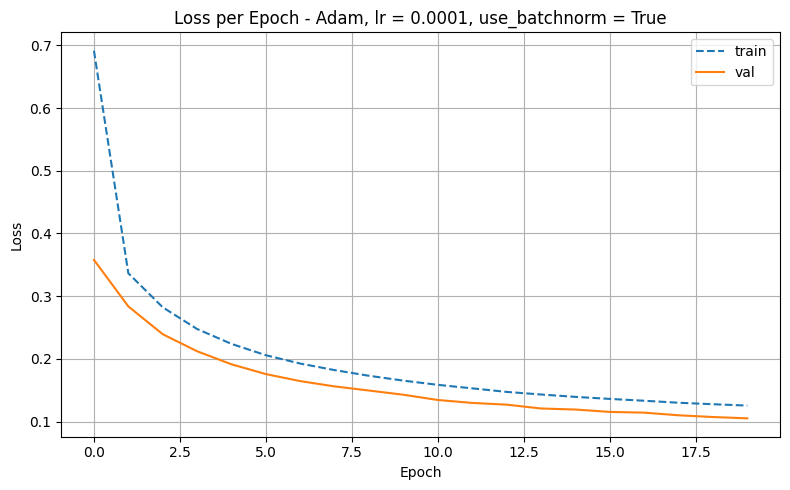

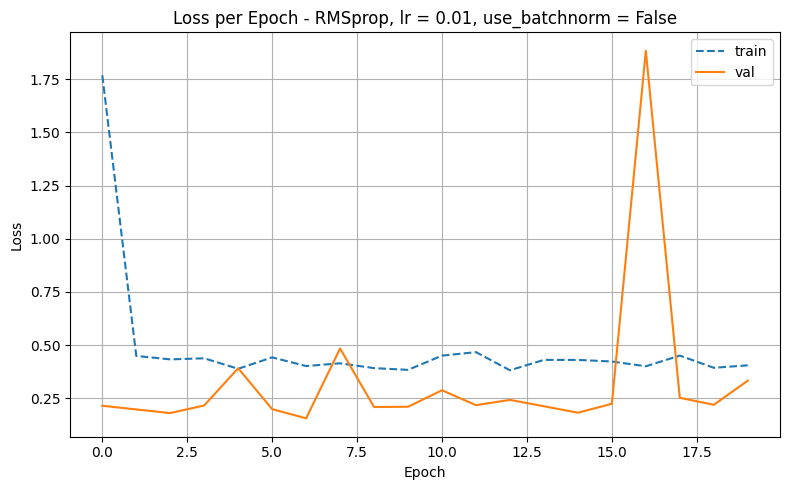

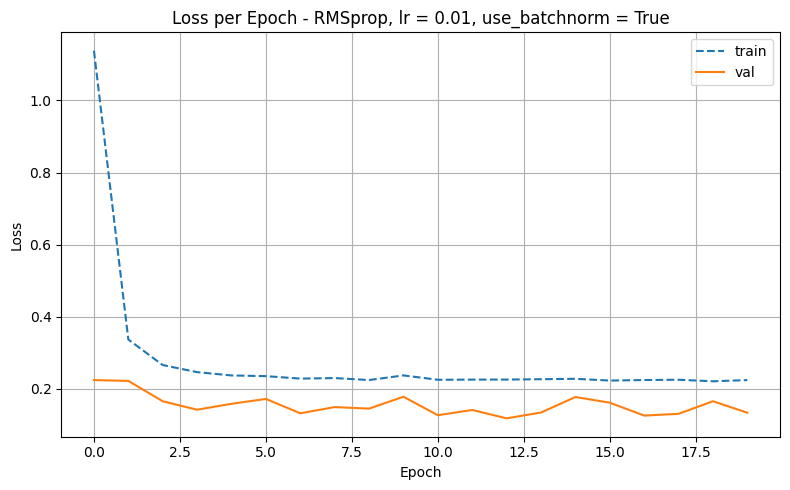

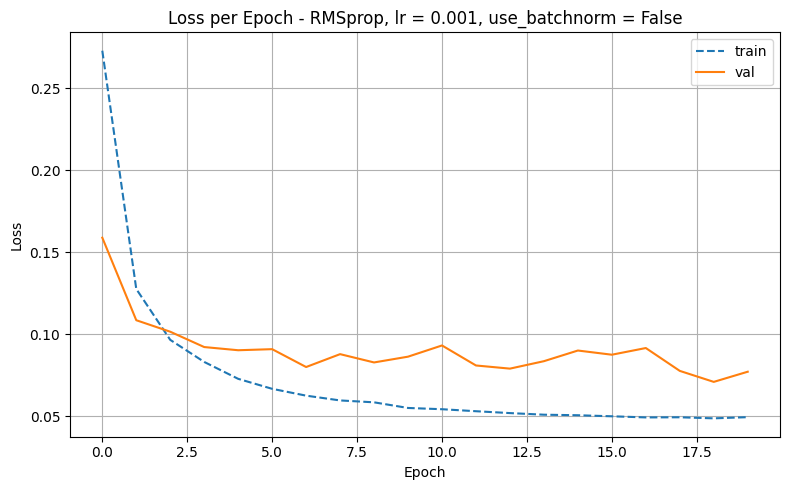

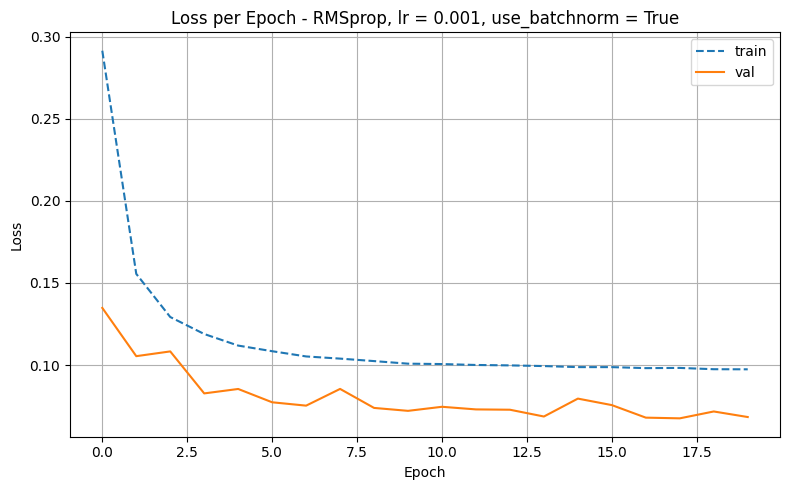

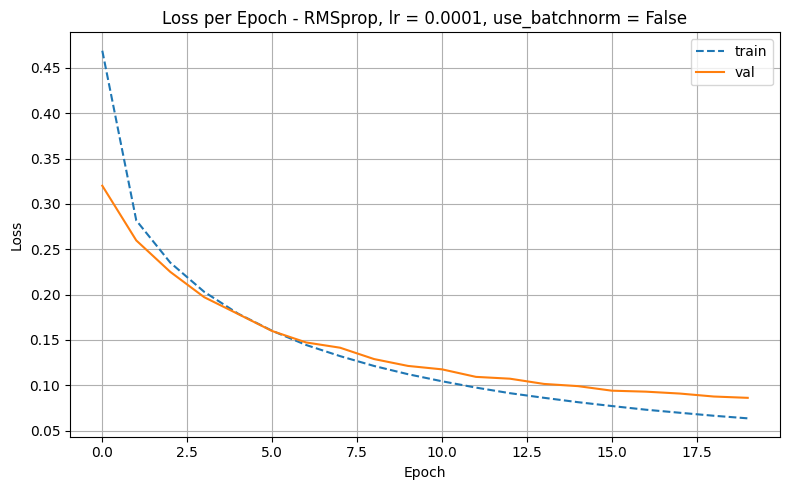

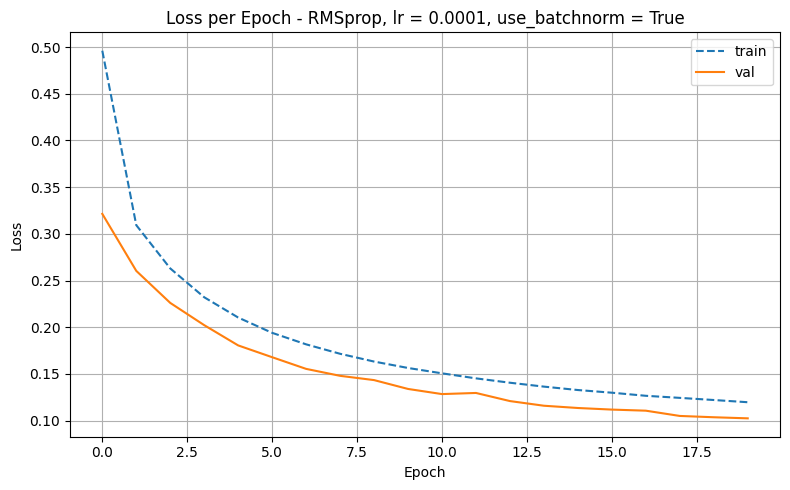

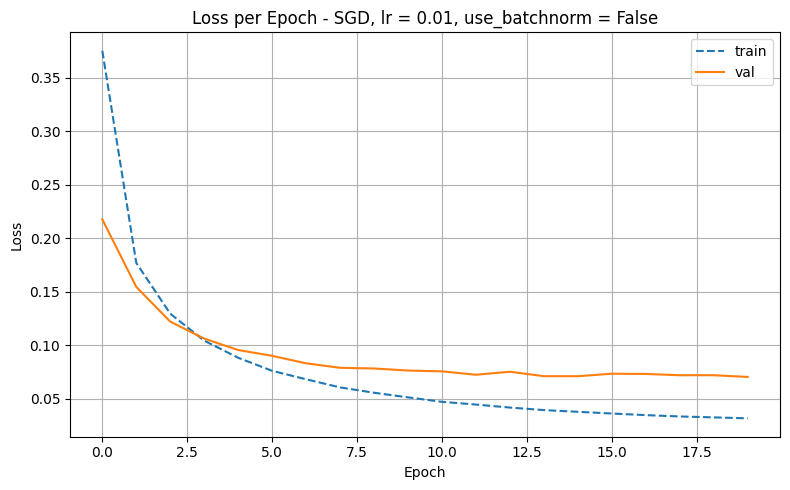

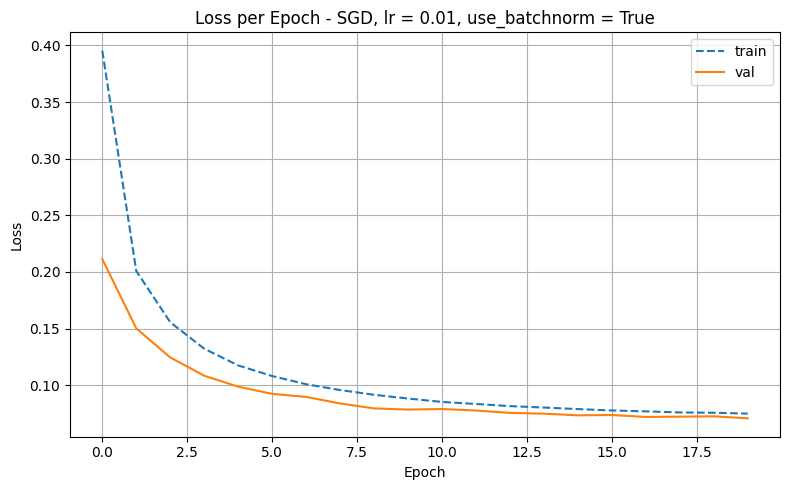

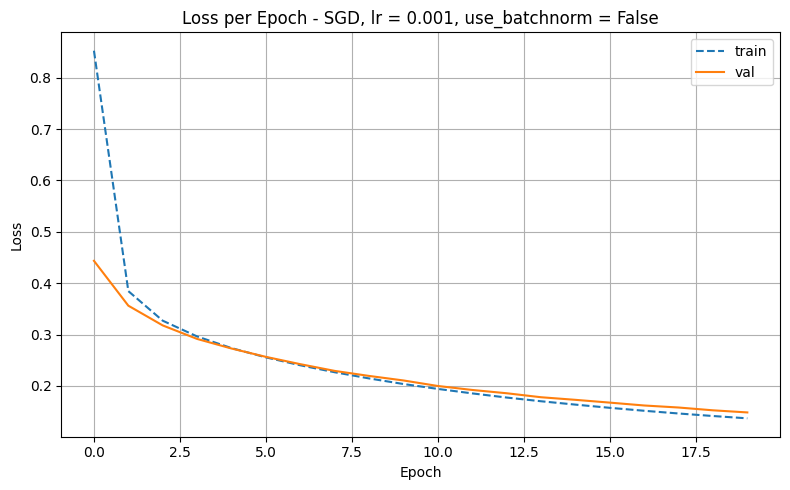

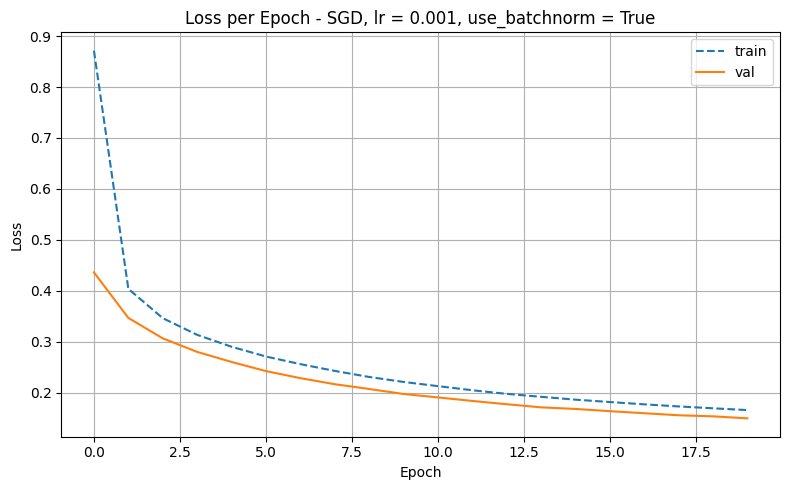

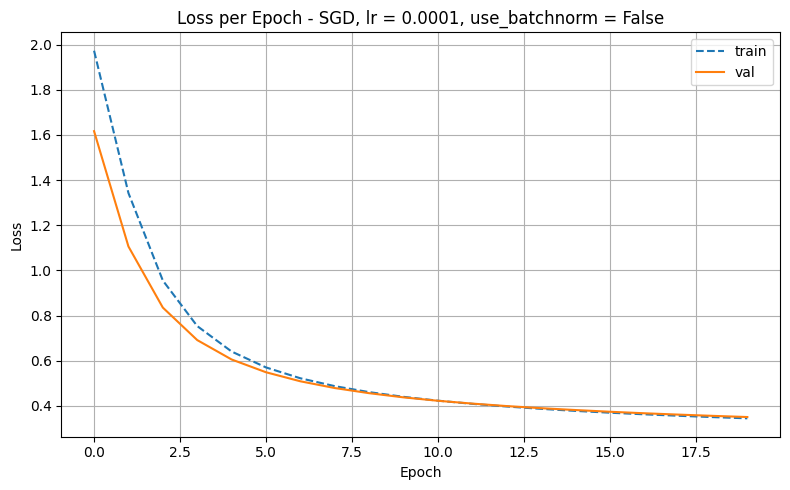

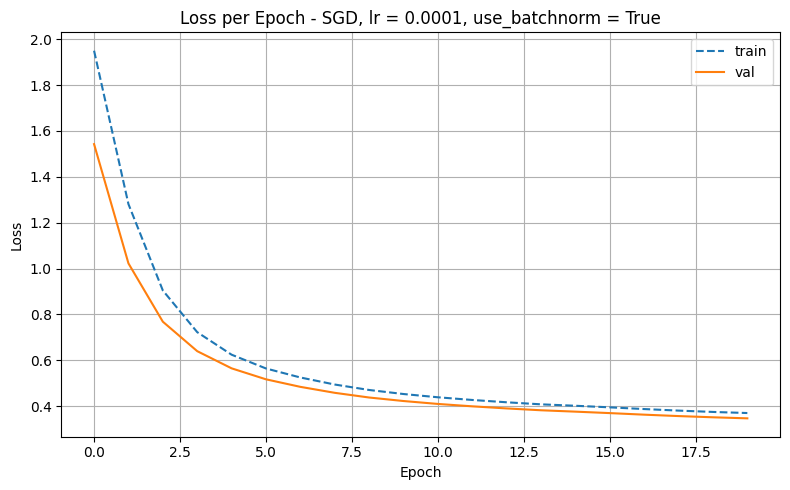

In [192]:
for tag, data in results.items():
    plt.figure(figsize=(8, 5))
    plt.plot(data["train_loss"], label="train", linestyle='dashed')
    plt.plot(data["val_loss"], label="val")
    plt.title(f"Loss per Epoch - {tag}")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


Можно заметить, что наиболее хаотичные данные у кастомного Адама, что в целом понятно. Так же в одном случае вылез артефакт, который может быть связан, в некотором перебое во время тестирования

## Лучшие комбинации

In [199]:
top_5 = sorted(results.items(), key=lambda x: x[1]['val_acc'], reverse=True)[:5]

for i, dict in enumerate(top_5):
    tag, metrics = dict
    print(f"{i + 1}. {tag}: Val Acc = {metrics['val_acc']:.4f}")

1. RMSprop, lr = 0.001, use_batchnorm = False: Val Acc = 0.9788
2. Adam, lr = 0.001, use_batchnorm = False: Val Acc = 0.9783
3. RMSprop, lr = 0.001, use_batchnorm = True: Val Acc = 0.9782
4. SGD, lr = 0.01, use_batchnorm = False: Val Acc = 0.9780
5. SGD, lr = 0.01, use_batchnorm = True: Val Acc = 0.9780


## Эксперимент, результаты и диаграмма (тестовый лоадер)

Проверим точность на тестовом лоадере среди лучших пяти на валидационном лоадере

1. RMSprop, lr = 0.001, use_batchnorm = True: Test Acc = 0.9815
2. SGD, lr = 0.01, use_batchnorm = True: Test Acc = 0.9809
3. RMSprop, lr = 0.001, use_batchnorm = False: Test Acc = 0.9808
4. SGD, lr = 0.01, use_batchnorm = False: Test Acc = 0.9806
5. Adam, lr = 0.001, use_batchnorm = False: Test Acc = 0.9792


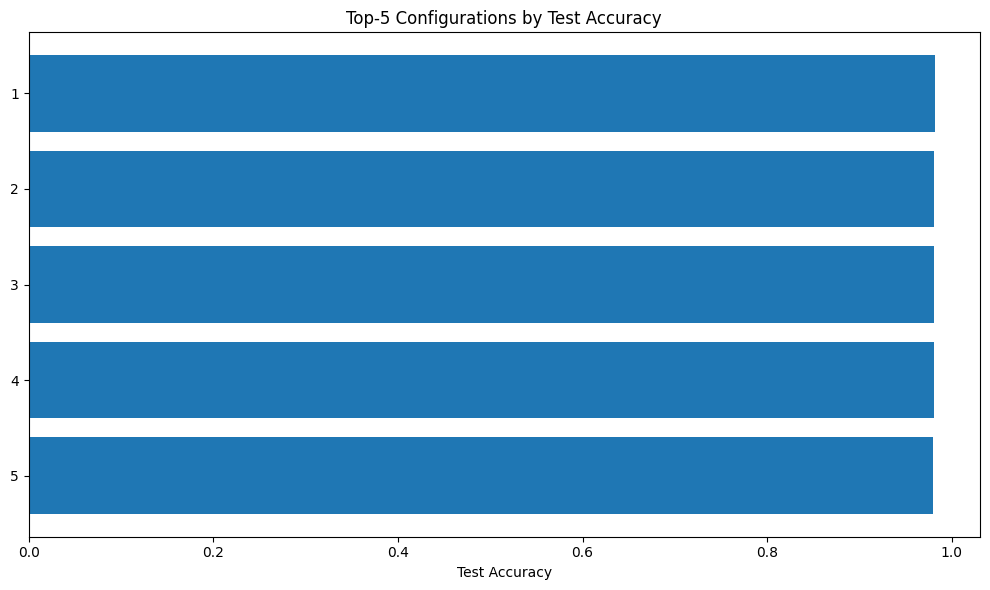

In [207]:
test_accuracies = {}

for tag, metrics in top_5:
    metrics['test_acc'] = metrics['trainer'].accuracy(test_loader)

top_5 = sorted(top_5, key=lambda x: x[1].get('test_acc', 0), reverse=True)

for i, dict in enumerate(top_5):
    tag, metrics = dict
    test_accuracies[tag] = metrics['test_acc']
    print(f"{i + 1}. {tag}: Test Acc = {metrics['test_acc']:.4f}")

tags = list(test_accuracies.keys())
accs = [test_accuracies[tag] for tag in tags]

plt.figure(figsize=(10, 6))
plt.barh(range(1,6), accs)
plt.xlabel("Test Accuracy")
plt.title("Top-5 Configurations by Test Accuracy")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

## Результаты

Лучшим результатом стала комбинация RMSprop, lr = 0.001 с включенным Batch Normalization. SGD же себя в среднем показала хуже всего. Там, в некоторых случаях точность была едва больше 0.9.

Также, как можно заметить наихудшим среди лучших образом себя показывает отсутствие Batch Normalization и кастомная реализация Адама, хотя валидационная выборка говорила об обратном.

Несмотря на это, датасет сам по себе не сильно сложный и все модели справились довольно хорошо.